Testing the Gaia Challenge simulated data in the case on a non costant or fixed anisotropy in the velocity of the stellar subcomponent. The profile adopted is the Osipkov-Merritt, which reads:
\begin{equation}
\beta(r)=\frac{r^2}{r^2+r^2_a}
\end{equation}
with $r_a = r_h$.

The stellar profile adopted here reads:
\begin{equation}
\nu_\ast(r) = \rho_h \left(\frac{r}{r_h}\right)^{-\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^{\alpha_\ast}\right)^\frac{\gamma_\ast-\beta_\ast}{\alpha_\ast}
\end{equation}
with parameters values:
* $\alpha_\ast$ = 2
* $\beta_\ast$ = 5
* $r_h$ = 0.1,0.25,1 kpc

leading to the simple expression
\begin{equation}
\nu_\ast(r) = \frac{\rho_h}{\left(\frac{r}{r_h}\right)^{\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^2\right)^{\frac{5-\gamma_\ast}{2}}}
\end{equation}

for $\gamma_\ast = 0.1,1$ this is referred to as "Plummer" and "non-Plummer" stellar profile, respectively.

In the non-Plummer profile case, the surface brightness profile has the following analytic expression:
\begin{equation}
I(R) = 2 \int^\infty_R \frac{\nu_\ast(r) r dr}{\sqrt{r^2-R^2}} = \rho_h \frac{r_h^2\left[(2r_h^2+R^2) csch^{-1}\left(\frac{R}{r_h}\right) - r_h\sqrt{r_h^2+R^2}\right]}{(r_h^2+R^2)^{3/2}}
\end{equation}

The $line-of-sight$ velocity dispersion $\sigma^2(R)$ that enters the Likelihood has the following expression
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{R}{I(R)}\int^\infty_1 \left(1-\frac{\beta(zR)}{z^2}\right)\frac{z}{\sqrt{z^2-1}}\frac{1}{z^2R^2+r^2_a}\int^\infty_{zR}\left(1+\left(\frac{r_a}{s}\right)^2\right)\nu_\ast(s)\mu(s/r_0)dsdz
\end{equation}
This can be cast in an dimensionless format by performing the following replacement:
\begin{equation}
\frac{s}{r_h} = y \quad \frac{r_h}{r_0} = \alpha \quad \frac{r_a}{r_h} = \delta \quad \frac{R}{r_h} = \gamma
\end{equation}
which lead to
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{\gamma}{I(R)}\int^\infty_1 \left(1-\frac{\beta(z,\delta,\gamma)}{z^2}\right)\frac{z}{\sqrt{z^2-1}}\frac{1}{\frac{z^2\gamma^2}{\delta^2}+1}\int^\infty_{z\gamma}\frac{\left[1+\left(\frac{y}{\delta}\right)^2\right]\nu_\ast(y)\mu(y\alpha)}{y^2}dsdz
\end{equation}

In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from AT import get_data
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions_simOM import integral2, Jfactor,nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/test/'
casedir = ['OsipkMerr_Core_nonPlum','OsipkMerr_Core_Plum','OsipkMerr_Cusp_nonPlum','OsipkMerr_Cusp_Plum']

# enter size of Mock dataset (options 100,1000,10000)
MockSize = 10000
# enter model choice - cf. casedir (options 1,2,3,4)
mod = 1

In [3]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] if mod == 2 or mod == 4 else \
rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.)

In [52]:
# Mock data preparation
data = ['/gs100_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_0.dat'%MockSize,      # OsipkMerr_Core_nonPlum
        '/gs010_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_0.dat'%MockSize,      # OsipkMerr_Core_Plum
        '/gs100_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_0.dat'%MockSize,      # OsipkMerr_Cusp_nonPlum
        '/gs010_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_0.dat'%MockSize]      # OsipkMerr_Cusp_Plum
err  = ['/gs100_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_0_err.dat'%MockSize,  # OsipkMerr_Core_nonPlum
        '/gs010_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_0_err.dat'%MockSize,  # OsipkMerr_Core_Plum
        '/gs100_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_0_err.dat'%MockSize,  # OsipkMerr_Cusp_nonPlum
        '/gs010_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_0_err.dat'%MockSize]  # OsipkMerr_Cusp_Plum
x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir[mod-1]+data[mod-1],unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
D=50.
d = np.sqrt(x**2+y**2+(D-z)**2)
v = (x*vx+y*vy+(D-z)*vz)/d
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir[mod-1]+err[mod-1],unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = np.absolute(Evx-vx),np.absolute(Evy-vy),np.absolute(Evz-vz)
dv = (x*Ex+y*Ey+(D-z)*Ez)/d

In [53]:
u=0.
rh= 0.25 if mod == 1 or mod == 2 else 0.1 
nstars=np.size(R)

In [54]:
#idx = np.arange(R.size)
#np.random.shuffle(idx)
#R,v,dv = R[idx],v[idx],dv[idx]

In [55]:
R, v, dv = R[8700:8800], v[8700:8800], dv[8700:8800]

In [56]:
gamma_array = R/rh
r0_array = np.logspace(-1,2,100)
ra_array = np.logspace(-2,2,100)
alpha_array = rh/r0_array
delta_array = ra_array/rh
A_array = np.array([gamma_array[i]/I(Ri,rh) for i,Ri in enumerate(R)])
I_array=np.zeros(shape=(len(A_array),len(ra_array),len(r0_array)))

In [57]:
def array_builder(gamma_array, delta_array, alpha_array):
    for k,gamma in enumerate(gamma_array):
        for i,delta in enumerate(delta_array):
            for j,alpha in enumerate(alpha_array):
                yield (k, i, j), (gamma, delta, alpha)

def proxy(args):
    return args[0], A_array[args[0][0]]*integral2(*args[1])

In [58]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(gamma_array, delta_array, alpha_array))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value

In [59]:
#I_array = np.load('Iarray_OM_Cusp_Plum_1000_3333_200.npy')
#np.save('Iarray_OM_Core_nonPlum_100_3333_200',I_array)

In [60]:
Jf = np.sqrt([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])

cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(J,i,j):
    I = cst*sqrt(J)*r0_array[j]**3*I_array[:,i,j]/Jf[j]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

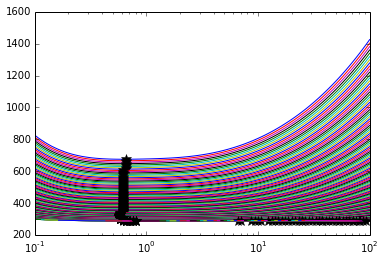

In [61]:
J_array = np.linspace(17,21,200)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
min_ra_arr = np.empty([0])
min_r0_arr = np.empty([0])

for J in J_array:                                                # scan over an array of J values
    r0_new = np.empty([0])
    ra_new = np.empty([0])
    LikeJr0 = np.empty([0])
    for j,r0 in enumerate(r0_array):                             # for each J scan over an array of r0 values
        LikeJra = np.zeros_like(ra_array)
        for i in range(ra_array.size): LikeJra[i] = logLike(10**J,i,j)
        interp_Like_ra = interp(ra_array,LikeJra)                  # build the profile likelihood along ra
        
        eval_Like_ra = np.logspace(log10(ra_array.min()),log10(ra_array.max()),1e3)
        min_Like_ra = interp_Like_ra(eval_Like_ra).min()
        min_ra = eval_Like_ra[np.where(interp_Like_ra(eval_Like_ra)==min_Like_ra)[0][0]]
        
        if ra_array[1]<min_ra<ra_array[-2]:
            LikeJr0 = np.append(LikeJr0,min_Like_ra)
            ra_new = np.append(ra_new,min_ra)
            r0_new = np.append(r0_new,r0)
    
    if LikeJr0.size>3:
        interp_ra = interp(r0_new,ra_new)
        interp_Like_r0 = interp(r0_new,LikeJr0)                  # build the profile likelihood along r0
        
        eval_Like_r0 = np.logspace(log10(r0_new.min()),log10(r0_new.max()),1e3)
        min_Like_r0 = interp_Like_r0(eval_Like_r0).min()
        min_r0 = eval_Like_r0[np.where(interp_Like_r0(eval_Like_r0)==min_Like_r0)[0][0]]
        
        if r0_new[1]<min_r0<r0_new[-2]:
            plt.semilogx(r0_new,interp_Like_r0(r0_new),label='J=%.2f'%J)
            plt.plot(min_r0,min_Like_r0,'*',markersize=10,c='k')

            min_ra_arr = np.append(min_ra_arr,interp_ra(min_r0))
            min_r0_arr = np.append(min_r0_arr,min_r0)
            min_LikeJ = np.append(min_LikeJ,min_Like_r0)
            J_new = np.append(J_new,J)

#plt.ylim(262,264)
#plt.xlim(1e-2,1e0)
#plt.legend(bbox_to_anchor=(1.4,1))

min J =  19.41  , ra =  1.044  , r0 =  0.808


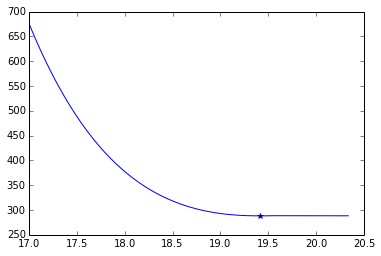

In [62]:
interp_Like_J  = interp(J_new,min_LikeJ)
interp_Like_ra = interp(J_new,min_ra_arr)
interp_Like_r0 = interp(J_new,min_r0_arr)

eval_Like_J = np.linspace(J_new.min(),J_new.max(),1e3)
min_Like_J  = interp_Like_J(eval_Like_J).min()
J_min       = eval_Like_J[np.where(interp_Like_J(eval_Like_J)==min_Like_J)[0][0]]

J_ra = float(interp_Like_ra(J_min))
J_r0 = float(interp_Like_r0(J_min))
print 'min J = ',round(J_min,2),' , ra = ',round(J_ra,3),' , r0 = ',round(J_r0,3)
plt.plot(J_new,interp_Like_J(J_new))
plt.plot(J_min,interp_Like_J(J_min),'b*')
#plt.ylim(250,270)

In [63]:
one_sigma_l = sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-0.5),
                                     method='Bounded',bounds=(J_new[0],J_min)).x-J_min
one_sigma_r = sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-0.5),
                                     method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

two_sigma_l = sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-2.),
                                     method='Bounded',bounds=(J_new[0],J_min)).x-J_min
two_sigma_r = sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-2.),
                                     method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

three_sigma_l = sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-4.),
                                     method='Bounded',bounds=(J_new[0],J_min)).x-J_min
three_sigma_r = sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-4.),
                                     method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

In [64]:
print round(J_min,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

19.41 -0.15 0.12 -0.28 0.12 -0.38 0.12


In [65]:
true_rho0 = 4e8 if mod == 1 or mod == 2 else 6.4e7
trueJ = round(np.log10(Jfactor(D,np.inf,1.,true_rho0,0.5)),2)
print 'true J : ',trueJ,', obtained J : ',round(J_min,2)

true J :  19.53 , obtained J :  19.41


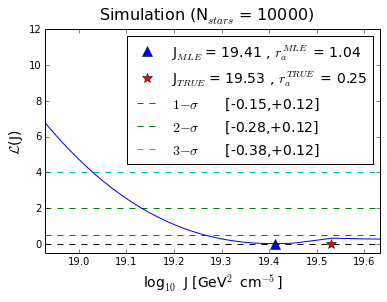

In [66]:
J_i = J_min+three_sigma_l-0.1
if J_min+three_sigma_r+0.1<J_new[-1]: J_f = J_min+three_sigma_r+0.1
else: J_f = J_new[-1]
J_plt = np.linspace(J_i,J_f,100)
plt.plot(J_plt,interp_Like_J(J_plt)-interp_Like_J(J_min))
plt.plot(J_min,0,'b^',markersize=10,label='J$_{MLE}$ = %.2f'%J_min+r' , $r^{MLE}_a$ = %.2f'%round(J_ra,3))
plt.plot(trueJ,0,'r*',markersize=10,label='J$_{TRUE}$ = %.2f'%trueJ+r' , $r^{TRUE}_a$ = %.2f'%rh)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%+.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%+.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%+.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,12)
plt.xlim(J_i,J_f)
#nstars=100
#plt.savefig(homedir+casedir[mod-1]+'/Sim%i_%s.png'%(nstars,casedir[mod-1]),dpi=300,format='png')
plt.suptitle(r'Simulation (N$_{stars}$ = %i)'%nstars,fontsize=16)
#plt.savefig(homedir+casedir[mod-1]+'/Sim%i_%s_title.png'%(nstars,casedir[mod-1]),dpi=300,format='png')

In [ ]:
J_rho0 = sciopt.minimize_scalar(lambda log10rho0:abs(J_min-np.log10(Jfactor(D,np.inf,J_r0,1.,0.5))-2*log10rho0)).x
print '%5s %10s %10s'%('','True','Best fit')
print '%5s %10.2f %10.2f'%('r0',1.,J_r0)
print '%5s %10.2f %10.2f'%('ra',0.10,J_ra)
print '%5s %10.2e %10.2e'%('rho0',4e8 if mod == 1 or mod == 2 else 6.4e7,10**J_rho0)

#output = open(homedir+casedir+'/results.dat','w')
#output.write('%5s %12s %12s \n'%('','True','Best fit'))
#output.write('%5s %10.2f %10.2f %2s \n'%('r0   = ',1,J_r0,'[kpc]'))
#output.write('%5s %10.2e %10.2e %2s'%('rho0 = ',true_rho0,10**J_rho0,'[Msun kpc^-3]'))
#output.close()